In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import albumentations as A

In [2]:
# Custom wrapper for albumentations transforms
import numpy as np
from PIL import Image

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL Image to numpy array
        if isinstance(img, Image.Image):
            img = np.array(img)
        # Apply albumentations transform with named argument
        augmented = self.transform(image=img)
        return augmented['image']

In [3]:
data_dir = './datasets'

# Load the dataset WITHOUT transforms first
# We will apply specific transforms to train/val/test splits later
full_dataset = ImageFolder(root=data_dir, transform=None)

# Calculate split sizes
train_size = int(0.8 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))
val_size = len(full_dataset) - train_size - test_size

In [4]:
#Get class names and number of classes
class_names = full_dataset.classes
num_classes = len(class_names)
print(f'Classes: {class_names}')
print(f'Number of classes: {num_classes}')

Classes: ['Lab', 'Tree', 'building', 'car', 'person']
Number of classes: 5


In [5]:
# Split the dataset into train, test, and validation sets using STRATIFIED split
# This ensures that each set has the same percentage of each class
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

# Get the targets (labels) for stratification
targets = full_dataset.targets# Get the targets (labels) for stratification


# First split: Train (80%) vs Temp (20%)
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets,
    random_state=42
)

# Get labels for the temp set to stratify the second split
temp_targets = [targets[i] for i in temp_idx]

# Second split: Val (50% of Temp -> 10% total) vs Test (50% of Temp -> 10% total)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    shuffle=True,
    stratify=temp_targets,
    random_state=42
)

# Create the subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1488
Val size: 186
Test size: 186


In [6]:
# Helper class to apply transforms to subsets
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

# Define data augmentations
# Added Resize before RandomCrop to ensure we don't crop small parts of large images
train_transform = AlbumentationsTransform(A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Blur(blur_limit=3, p=0.2),
    #A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
]))

val_transform = AlbumentationsTransform(A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
]))

# Apply transforms using the wrapper class
# This fixes the issue where modifying .dataset.transform affected ALL splits
train_dataset = ApplyTransform(train_dataset, transform=train_transform)
val_dataset = ApplyTransform(val_dataset, transform=val_transform)
test_dataset = ApplyTransform(test_dataset, transform=val_transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [8]:
#import the model and modify the final layer
class CustomeResnet(nn.Module):
    def __init__(self, num_classes):
        super(CustomeResnet, self).__init__()
        self.model = torchvision.models.resnet34(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, in_features // 2),
            nn.BatchNorm1d(in_features // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)
model = CustomeResnet(num_classes=num_classes)

/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Calculate class weights to handle class imbalance
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# Get the targets (labels) for stratification

# Extract labels from the train dataset indices
# Access .subset.indices because train_dataset is now an ApplyTransform wrapper
train_labels = [full_dataset.targets[i] for i in train_dataset.subset.indices]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f'Class weights: {class_weights}')

Class weights: tensor([1.7006, 0.7259, 1.1188, 0.7811, 1.1625])


In [10]:
for param in model.model.parameters():
    param.requires_grad = False

for param in model.model.layer4.parameters():
    param.requires_grad = True
for param in model.model.layer3.parameters():
    param.requires_grad = True
for param in model.model.fc.parameters():
    param.requires_grad = True

In [11]:
#Define optimizer and loss function with learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [12]:
# change the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU compatibility
if torch.cuda.is_available():
	print(f"GPU: {torch.cuda.get_device_name(0)}")
	print(f"CUDA Version: {torch.version.cuda}")
	print(f"PyTorch Version: {torch.__version__}")
	print(f"GPU Compute Capability: {torch.cuda.get_device_capability(0)}")

# Move model to device
model = model.to(device)
criterion = criterion.to(device)


Using device: cpu


In [13]:
# Check if CUDA is properly configured, otherwise use CPU
try:
    # Test CUDA with a simple operation
    test_tensor = torch.tensor([1.0]).to(device)
    test_result = test_tensor * 2
    print(f"CUDA test passed, using device: {device}")
except RuntimeError as e:
    print(f"CUDA error detected: {e}")
    print("Falling back to CPU")
    device = torch.device("cpu")
    model = model.to(device)
    criterion = criterion.to(device)

#Training loop with validation, learning rate scheduling, and model saving
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Step the scheduler based on validation loss
    scheduler.step(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('  ✓ Best model saved!')
    print()

CUDA test passed, using device: cpu


/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/50
  Train Loss: 0.4253, Train Acc: 86.90%
  Val Loss: 0.9543, Val Acc: 82.80%
  LR: 0.001000
  ✓ Best model saved!

Epoch 2/50
  Train Loss: 0.2880, Train Acc: 91.53%
  Val Loss: 0.2440, Val Acc: 91.94%
  LR: 0.001000
  ✓ Best model saved!

Epoch 3/50
  Train Loss: 0.2407, Train Acc: 92.88%
  Val Loss: 0.2448, Val Acc: 93.55%
  LR: 0.001000
  ✓ Best model saved!

Epoch 4/50
  Train Loss: 0.1688, Train Acc: 95.03%
  Val Loss: 0.2342, Val Acc: 94.62%
  LR: 0.001000
  ✓ Best model saved!



KeyboardInterrupt: 

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

# measure test accuracy
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 93.55%


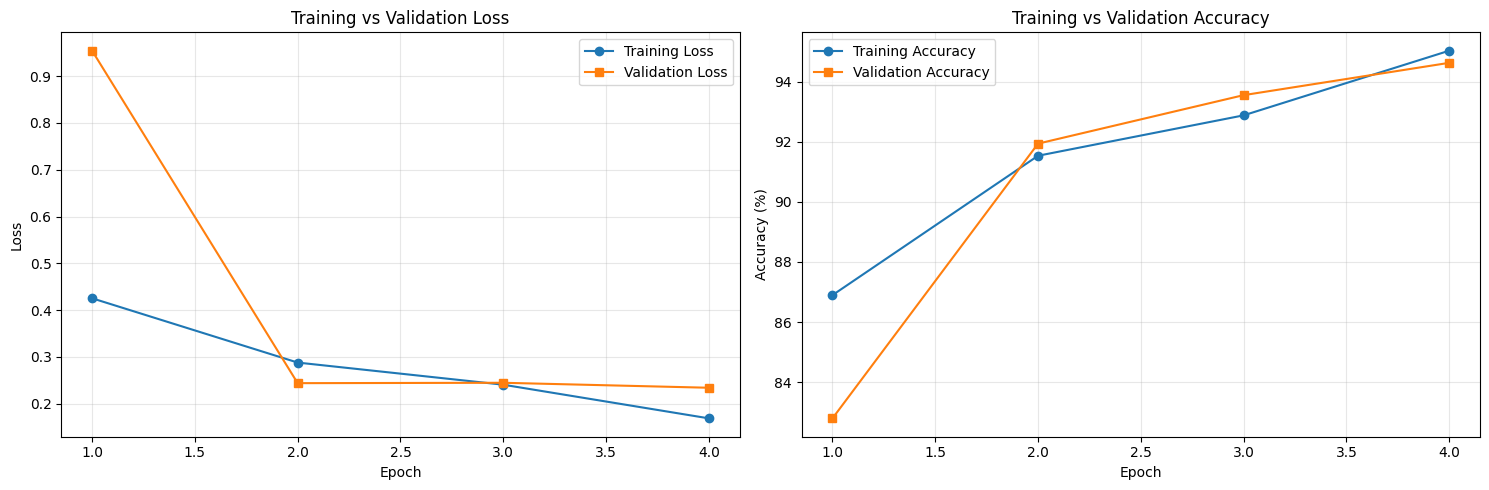

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(train_losses) + 1)

# Plot losses
ax1.plot(epochs, train_losses, label="Training Loss", marker='o')
ax1.plot(epochs, val_losses, label="Validation Loss", marker='s')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
ax2.plot(epochs, val_accuracies, label="Validation Accuracy", marker='s')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training vs Validation Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')                          
print(cm)
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

Confusion Matrix:
[[21  0  0  0  1]
 [ 0 51  0  1  0]
 [ 3  1 28  0  1]
 [ 2  0  2 43  0]
 [ 1  0  0  0 31]]
Classification Report:
              precision    recall  f1-score   support

         Lab       0.78      0.95      0.86        22
        Tree       0.98      0.98      0.98        52
    building       0.93      0.85      0.89        33
         car       0.98      0.91      0.95        47
      person       0.94      0.97      0.95        32

    accuracy                           0.94       186
   macro avg       0.92      0.93      0.93       186
weighted avg       0.94      0.94      0.94       186

